In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
print('Python version: ', sys.version)

Python version:  3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 18:53:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar # check if a date is holiday

plt.rcParams['figure.figsize'] = (16, 7)

# Loading cleaned turnstile data

In [4]:
def load_diff_data(filename):
    diff = pd.read_csv(filename, low_memory=False)
    diff['LINENAME'] =  diff['LINENAME'].astype(str)
    # parse datetime
    diff['datetime'] = pd.to_datetime(diff.datetime)
    diff['date'] = diff.datetime.dt.date
    diff['time'] = diff.datetime.dt.time
    # day of a week
    diff['dayofweek'] = diff.datetime.dt.weekday
    # check holiday
    cal = calendar()
    holidays = cal.holidays(diff['date'].min(),diff['date'].max())
    print('holidays:\n', holidays)
    diff['isholiday'] = diff['datetime'].dt.date.astype('datetime64').isin(holidays)
    # is workday: not weekend or holiday
    diff['isworkday'] = (diff['dayofweek'] < 5) & (diff['isholiday'] == False)
    diff.info()
    return diff
diff_test = load_diff_data('../data/turnstile/turnstile_diffs_test.csv.zip')

holidays:
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200493 entries, 0 to 200492
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   C/A        200493 non-null  object        
 1   UNIT       200493 non-null  object        
 2   SCP        200493 non-null  object        
 3   STATION    200493 non-null  object        
 4   LINENAME   200493 non-null  object        
 5   DIVISION   200493 non-null  object        
 6   datetime   200493 non-null  datetime64[ns]
 7   entries    200493 non-null  float64       
 8   exits      200493 non-null  float64       
 9   date       200493 non-null  object        
 10  time       200493 non-null  object        
 11  dayofweek  200493 non-null  int64         
 12  isholiday  200493 non-null  bool          
 13  isworkday  200493 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(2), int64(1),

In [5]:
%%time
diff20 = load_diff_data('../data/turnstile/turnstile_diffs_2020.csv.zip')
diff19 = load_diff_data('../data/turnstile/turnstile_diffs_2019.csv.zip')

holidays:
 DatetimeIndex(['2020-01-01', '2020-01-20', '2020-02-17'], dtype='datetime64[ns]', freq=None)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3776138 entries, 0 to 3776137
Data columns (total 14 columns):
 #   Column     Dtype         
---  ------     -----         
 0   C/A        object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   LINENAME   object        
 5   DIVISION   object        
 6   datetime   datetime64[ns]
 7   entries    float64       
 8   exits      float64       
 9   date       object        
 10  time       object        
 11  dayofweek  int64         
 12  isholiday  bool          
 13  isworkday  bool          
dtypes: bool(2), datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 352.9+ MB
holidays:
 DatetimeIndex(['2019-01-01', '2019-01-21', '2019-02-18', '2019-05-27'], dtype='datetime64[ns]', freq=None)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4347272 entries, 0 to 43472

# 1. Overall change
## Total turnstile entries and exits in 2019 and 2020 

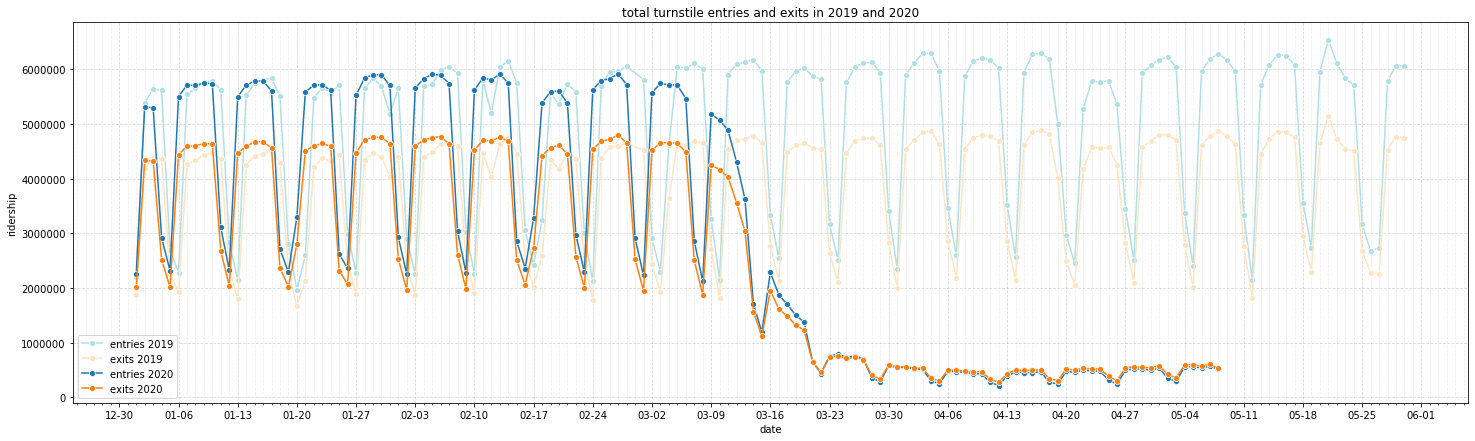

In [6]:
def plot_total(df19, df20):
    total19 = df19.groupby('date', as_index=False).agg({'entries':'sum', 'exits':'sum'})
    total20 = df20.groupby('date', as_index=False).agg({'entries':'sum', 'exits':'sum'})

    total19 = total19.loc[total19['date'] <= pd.to_datetime('2019-05-30')]
    total19['date'] = np.where(total19['date'] <= pd.to_datetime('2019-02-28'),
        total19['date'] + pd.Timedelta(days=365), total19['date'] + pd.Timedelta(days=366))

    fig, ax = plt.subplots(figsize=(25, 7))
    sns.lineplot(ax=ax, x="date", y='entries', data=total19, marker='o', color='powderblue', label='entries 2019')
    sns.lineplot(ax=ax, x="date", y='exits', data=total19, marker='o', color='bisque', label='exits 2019')
    sns.lineplot(ax=ax, x="date", y='entries', data=total20, marker='o', color='#1f77b4', label='entries 2020')
    sns.lineplot(ax=ax, x="date", y='exits', data=total20, marker='o', color='#ff7f0e', label='exits 2020')
    ax.legend(loc='lower left')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO)) #tick on monday
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.grid(linestyle='--',alpha=0.5, which='major')
    ax.grid(linestyle='--',alpha=0.2, which='minor')
    #plt.xticks(rotation=60)
    ax.set_ylabel('ridership')
    plt.title('total turnstile entries and exits in 2019 and 2020')
    plt.show()

plot_total(diff19 ,diff20)

## Overall subway mobility change
- How much did ridership change compared to previous months and year?
- How do policies affect the trend?

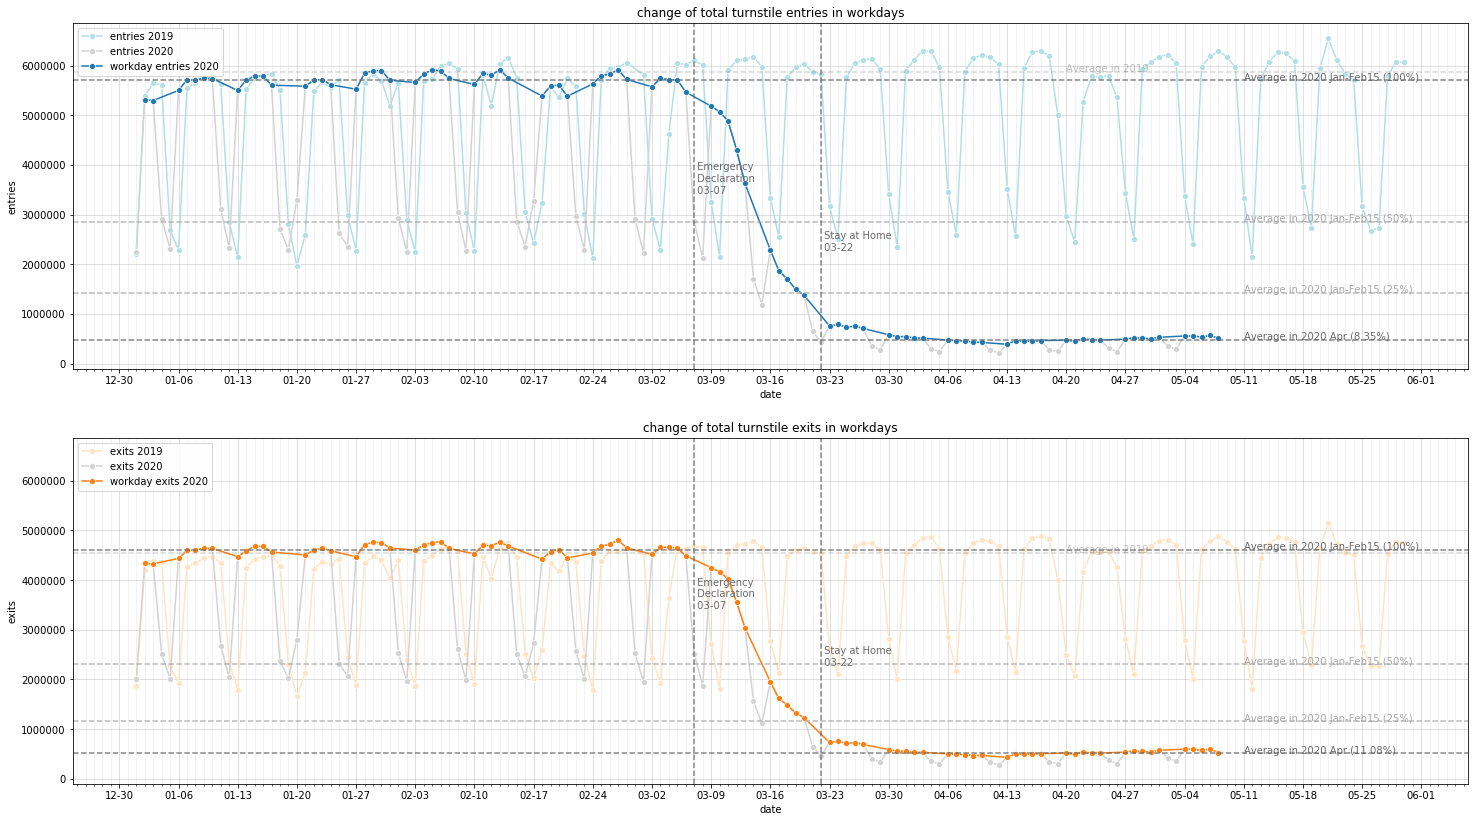

In [7]:
def process_daily_total(df):
    total = df.groupby(['date', 'isworkday'], as_index=False).agg({'entries':'sum', 'exits':'sum'})
    avg_weekday_ent = total.loc[total['isworkday']]['entries'].mean()
    avg_weekday_exi = total.loc[total['isworkday']]['exits'].mean()
    return total, [avg_weekday_ent, avg_weekday_exi]

def plot_total_weekday_change(df19, df20):
    # total
    total19,avg19 = process_daily_total(df19.loc[df19['date'] <= pd.to_datetime('2019-05-30')])
    total20,_ = process_daily_total(df20)
    # remove holidays
    total20_wk = total20.loc[total20['isworkday']]
    # 2020 before march
    _, avg20_jan = process_daily_total(df20.loc[df20['date'] <= pd.to_datetime('2020-02-15')])
    _, avg20_apr = process_daily_total(df20.loc[(df20['date'] >= pd.to_datetime('2020-04-01'))
                                                & (df20['date'] < pd.to_datetime('2020-05-01'))])
    # align 2019
    total19['date'] = np.where(total19['date'] <= pd.to_datetime('2019-02-28'),
        total19['date'] + pd.Timedelta(days=365), total19['date'] + pd.Timedelta(days=366))

    fig, axs = plt.subplots(nrows=2, figsize=(25, 14))
    sns.lineplot(ax=axs[0], x="date", y='entries', data=total19, marker='o', color='powderblue', label='entries 2019')
    sns.lineplot(ax=axs[0], x="date", y='entries', data=total20, marker='o', color='lightgrey', label='entries 2020')
    sns.lineplot(ax=axs[0], x="date", y='entries', data=total20_wk, marker='o', color='#1f77b4', label='workday entries 2020')
    sns.lineplot(ax=axs[1], x="date", y='exits', data=total19, marker='o', color='bisque', label='exits 2019')
    sns.lineplot(ax=axs[1], x="date", y='exits', data=total20, marker='o', color='lightgrey', label='exits 2020')
    sns.lineplot(ax=axs[1], x="date", y='exits', data=total20_wk, marker='o', color='#ff7f0e', label='workday exits 2020')
    # ticks and grid style
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.grid(linestyle='-',alpha=0.5, which='major')
        ax.grid(linestyle='-',alpha=0.2, which='minor')
        ax.legend(loc='upper left')
    # same y scale in both plots
    ylim = axs[0].get_ylim()
    axs[1].set_ylim(ylim[0], ylim[1])
    # annotations
    for i, ax in enumerate(axs):
        # 2019 Jan-May
        axs[i].axhline(y=avg19[i], linestyle='dashed', color='grey', alpha=0.3)
        axs[i].text(y=avg19[i], x=dt.datetime(2020,4,20), s='Average in 2019', color='grey', alpha=0.5)
        # 2020 Jan-Feb15
        axs[i].axhline(y=avg20_jan[i], linestyle='dashed', color='dimgray', alpha=0.8)
        axs[i].text(y=avg20_jan[i], x=dt.datetime(2020,5,11), s='Average in 2020 Jan-Feb15 (100%)', color='dimgray')
        # 2020 Jan-Feb 50%, 25%, 12.5%
        for r,text in [(0.5, '50%'), (0.25, '25%')]:
            axs[i].axhline(y=avg20_jan[i]*r, linestyle='dashed', color='darkgrey', alpha=0.8)
            axs[i].text(y=avg20_jan[i]*r, x=dt.datetime(2020,5,11),
                s='Average in 2020 Jan-Feb15 ('+text+')', color='darkgrey')
        # 2020 April
        axs[i].axhline(y=avg20_apr[i], linestyle='dashed', color='dimgray', alpha=0.8)
        axs[i].text(y=avg20_apr[i], x=dt.datetime(2020,5,11),
                    s='Average in 2020 Apr ('+"{:.2%}".format(avg20_apr[i]/avg20_jan[i])+')', color='dimgray')
        # dates
        # 3-7 emergency declaration
        axs[i].axvline(x=dt.datetime(2020,3,7), linestyle='dashed', color='dimgray', alpha=0.8)
        axs[i].text(x=dt.datetime(2020,3,7), y=ylim[1]/2, s=' Emergency\n Declaration\n 03-07', color='dimgray')
        # 3-22 stay at home
        axs[i].axvline(x=dt.datetime(2020,3,22), linestyle='dashed', color='dimgray', alpha=0.8)
        axs[i].text(x=dt.datetime(2020,3,22), y=ylim[1]/3, s=' Stay at Home\n 03-22', color='dimgray')
    axs[0].title.set_text('change of total turnstile entries in workdays')
    axs[1].title.set_text('change of total turnstile exits in workdays')
    plt.show()

process_daily_total(diff19)
plot_total_weekday_change(diff19 ,diff20)

# 2. Changes by station
## Top stations by daily average (in regular days and in April)

In [8]:
def get_top_average(total, from_date_str, to_date_str, topk):
    total = total.loc[(total.isworkday==True) & (total.date >= pd.to_datetime(from_date_str))
        & (total.date <= pd.to_datetime(to_date_str))]
    avg = total.groupby(['STATION', 'lines'], as_index=False).agg({'entries':'mean', 'exits':'mean'})
    top_ent = avg.nlargest(topk, 'entries')
    top_exi = avg.nlargest(topk, 'exits')
    return [top_ent, top_ent], avg

def get_top_stations(df, topk):
    df['lines'] = df.LINENAME.apply(lambda name: ''.join(sorted(name)))
    total = df.groupby(['STATION', 'lines', 'date', 'isworkday'], as_index=False).agg({'entries':'sum', 'exits':'sum'})
    reg_top, reg_avg = get_top_average(total, '2020-01-01', '2020-02-15', topk)
    print('top stations in regular workdays:\n', pd.concat(reg_top).drop_duplicates())
    apr_top, apr_avg = get_top_average(total, '2020-04-01', '2020-04-30', topk)
    print('top stations in april workdays:\n', pd.concat(apr_top).drop_duplicates())
    top_ent = pd.concat([reg_top[0][['STATION', 'lines']], apr_top[0][['STATION', 'lines']]]).drop_duplicates()
    top_exi = pd.concat([reg_top[1][['STATION', 'lines']], apr_top[1][['STATION', 'lines']]]).drop_duplicates()
    reg_avg = reg_avg.rename(columns={'entries':'regular_avg_entries', 'exits':'regular_avg_exits'})
    apr_avg = apr_avg.rename(columns={'entries':'april_avg_entries', 'exits':'april_avg_exits'})
    avg = pd.merge(reg_avg, apr_avg)
    return top_ent, top_exi, total, avg

top_ent, top_exi, total, avg = get_top_stations(diff20, 10)

top stations in regular workdays:
              STATION         lines        entries          exits
304  GRD CNTRL-42 ST         4567S  145570.774194  143690.000000
86   34 ST-HERALD SQ      BDFMNQRW  118809.193548  111180.935484
26    14 ST-UNION SQ      456LNQRW   94770.645161   91296.612903
295        FULTON ST      2345ACJZ   89945.387097   83392.903226
99   42 ST-PORT AUTH  1237ACENQRSW   86306.225806   70713.935484
90    34 ST-PENN STA           ACE   80188.225806   75643.354839
439   TIMES SQ-42 ST  1237ACENQRSW   74065.645161   81208.806452
120   59 ST COLUMBUS         1ABCD   67920.548387   57180.806452
103   47-50 STS ROCK          BDFM   62168.967742   63288.645161
395     PATH NEW WTC             1   60246.387097   54270.225806
top stations in april workdays:
              STATION         lines      entries        exits
26    14 ST-UNION SQ      456LNQRW  6485.000000  7874.363636
325   JAMAICA CENTER           EJZ  5564.409091  6196.545455
86   34 ST-HERALD SQ      BDFMNQRW

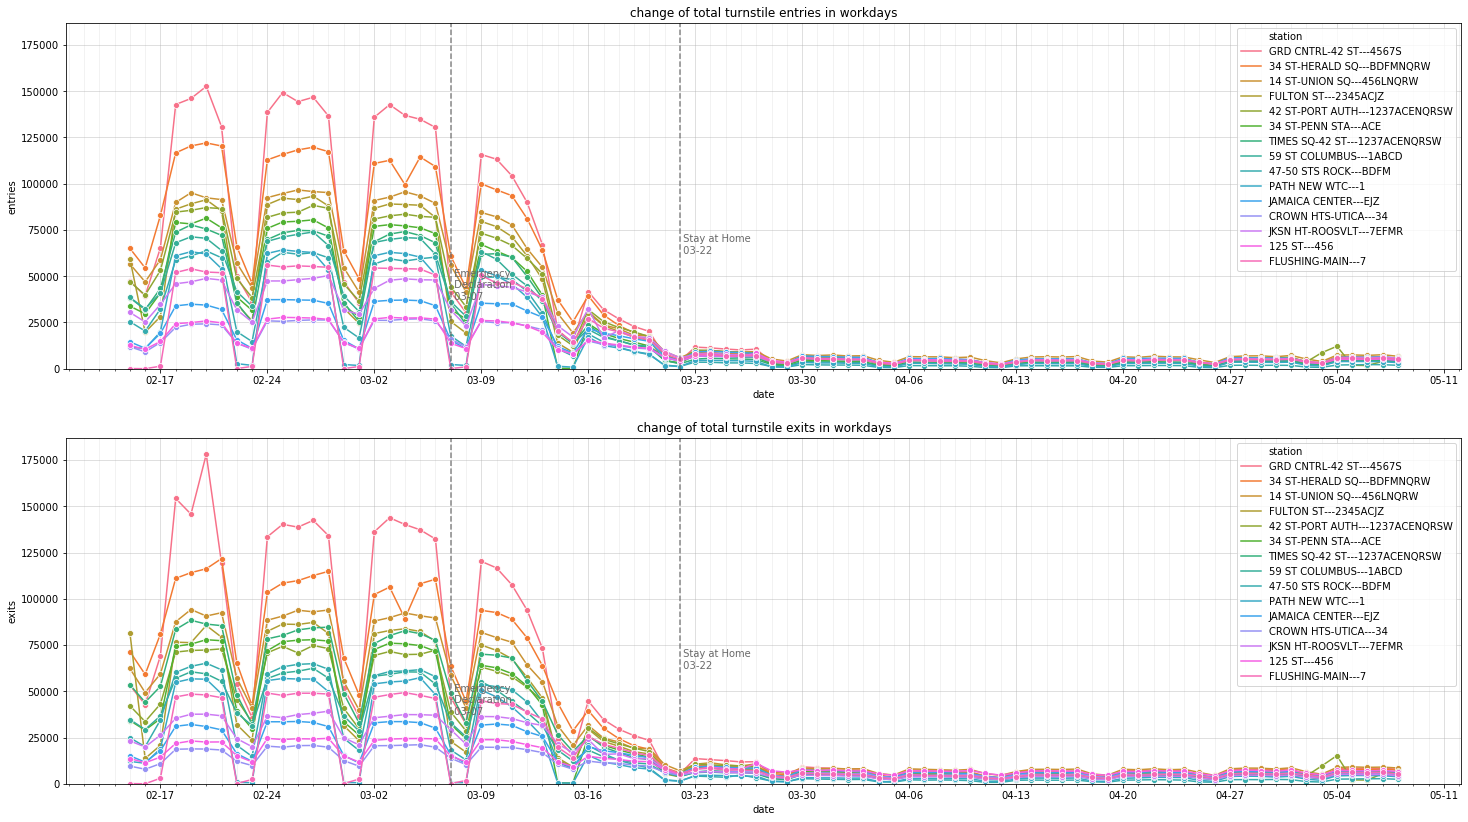

In [9]:
def plot_top_stations(top_ent, top_exi, total, annote=True):
    top_stations = pd.concat([top_ent, top_exi]).drop_duplicates()
    station_total = pd.merge(top_stations, total)
    station_total['station'] = station_total.STATION + '---' + station_total.lines
    fig, axs = plt.subplots(nrows=2, figsize=(25, 14))
    sns.lineplot(ax=axs[0], x="date", y='entries', hue='station',
                 data=station_total, marker='o', color='powderblue')
    sns.lineplot(ax=axs[1], x="date", y='exits', hue='station',
                 data=station_total, marker='o', color='powderblue')
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.grid(linestyle='-',alpha=0.5, which='major')
        ax.grid(linestyle='-',alpha=0.2, which='minor')
        ax.legend(loc='upper right')
    # same y scale in both plots
    ylim = axs[1].get_ylim()
    axs[0].set_ylim(0, ylim[1])
    axs[1].set_ylim(0, ylim[1])
    # annotations
    if annote:
        for i, ax in enumerate(axs):
            # dates
            # 3-7 emergency declaration
            axs[i].axvline(x=dt.datetime(2020,3,7), linestyle='dashed', color='dimgray', alpha=0.8)
            axs[i].text(x=dt.datetime(2020,3,7), y=ylim[1]/5, s=' Emergency\n Declaration\n 03-07', color='dimgray')
            # 3-22 stay at home
            axs[i].axvline(x=dt.datetime(2020,3,22), linestyle='dashed', color='dimgray', alpha=0.8)
            axs[i].text(x=dt.datetime(2020,3,22), y=ylim[1]/3, s=' Stay at Home\n 03-22', color='dimgray')
        axs[0].title.set_text('change of total turnstile entries in workdays')
    axs[1].title.set_text('change of total turnstile exits in workdays')
    plt.show()
plot_top_stations(top_ent, top_exi, total.loc[total.date >= pd.to_datetime('2020-02-15')])

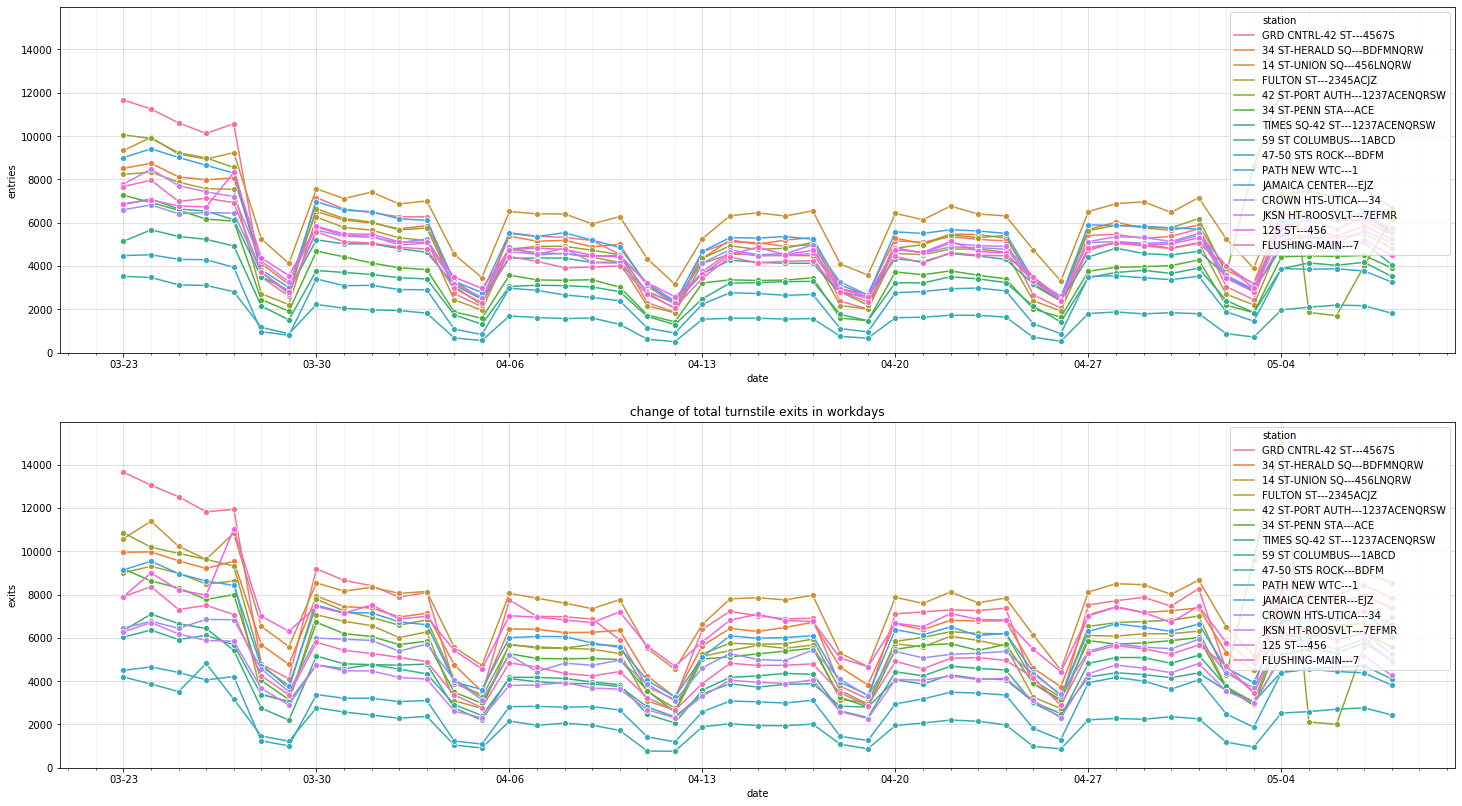

In [10]:
plot_top_stations(top_ent, top_exi, total.loc[total.date >= pd.to_datetime('2020-03-23')], False)

## Station Locations

In [11]:
def load_station_line_geolocation(filename):
    loc = pd.read_csv(filename, low_memory=False)
    loc.dropna()
    loc['lines'] = loc['lines'].astype(str)
    return loc
station_line_loc = load_station_line_geolocation('../data/turnstile/geocoded_station_lines.csv')
station_line_loc.head()

,STATION,lines,latitude,longitude,zipcode,state,borough,neighborhood
0,1 AV,L,40.730901,-73.981719,10009,NY,Manhattan,Lower East Side
1,103 ST,1,40.799354,-73.968329,10025,NY,Manhattan,Upper West Side
2,103 ST,6,40.790582,-73.947473,10029,NY,Manhattan,East Harlem
3,103 ST,BC,40.796105,-73.961399,10162,NY,Manhattan,-
4,103 ST-CORONA,7,40.749858,-73.862672,11368,NY,Queens,West Queens


In [12]:
station_avg_loc = pd.merge(avg, station_line_loc)
station_avg_loc.head()

,STATION,lines,regular_avg_entries,regular_avg_exits,april_avg_entries,april_avg_exits,latitude,longitude,zipcode,state,borough,neighborhood
0,1 AV,L,17838.419355,20279.903226,1481.500000,2412.818182,40.730901,-73.981719,10009,NY,Manhattan,Lower East Side
1,103 ST,1,11657.129032,6219.935484,1005.045455,895.272727,40.799354,-73.968329,10025,NY,Manhattan,Upper West Side
2,103 ST,6,13422.096774,12478.677419,2115.000000,2669.727273,40.790582,-73.947473,10029,NY,Manhattan,East Harlem
3,103 ST,BC,4637.193548,3146.677419,432.000000,406.045455,40.796105,-73.961399,10162,NY,Manhattan,-
4,103 ST-CORONA,7,20293.967742,15113.064516,2518.409091,2686.909091,40.749858,-73.862672,11368,NY,Queens,West Queens


            STATION         lines    borough  april_avg_entries
8    47-50 STS ROCK          BDFM  Manhattan        1685.636364
6    TIMES SQ-42 ST  1237ACENQRSW  Manhattan        3288.136364
5    34 ST-PENN STA           ACE  Manhattan        3594.818182
7    59 ST COLUMBUS         1ABCD  Manhattan        4384.045455
13    FLUSHING-MAIN             7     Queens        4433.636364
3         FULTON ST      2345ACJZ  Manhattan        4723.409091
12           125 ST           456  Manhattan        4766.590909
11  JKSN HT-ROOSVLT         7EFMR     Queens        4772.909091
10  CROWN HTS-UTICA            34   Brooklyn        4810.818182
4   42 ST-PORT AUTH  1237ACENQRSW  Manhattan        5197.090909
0   GRD CNTRL-42 ST         4567S  Manhattan        5329.227273
1   34 ST-HERALD SQ      BDFMNQRW  Manhattan        5360.227273
9    JAMAICA CENTER           EJZ     Queens        5564.409091
2    14 ST-UNION SQ      456LNQRW  Manhattan        6485.000000


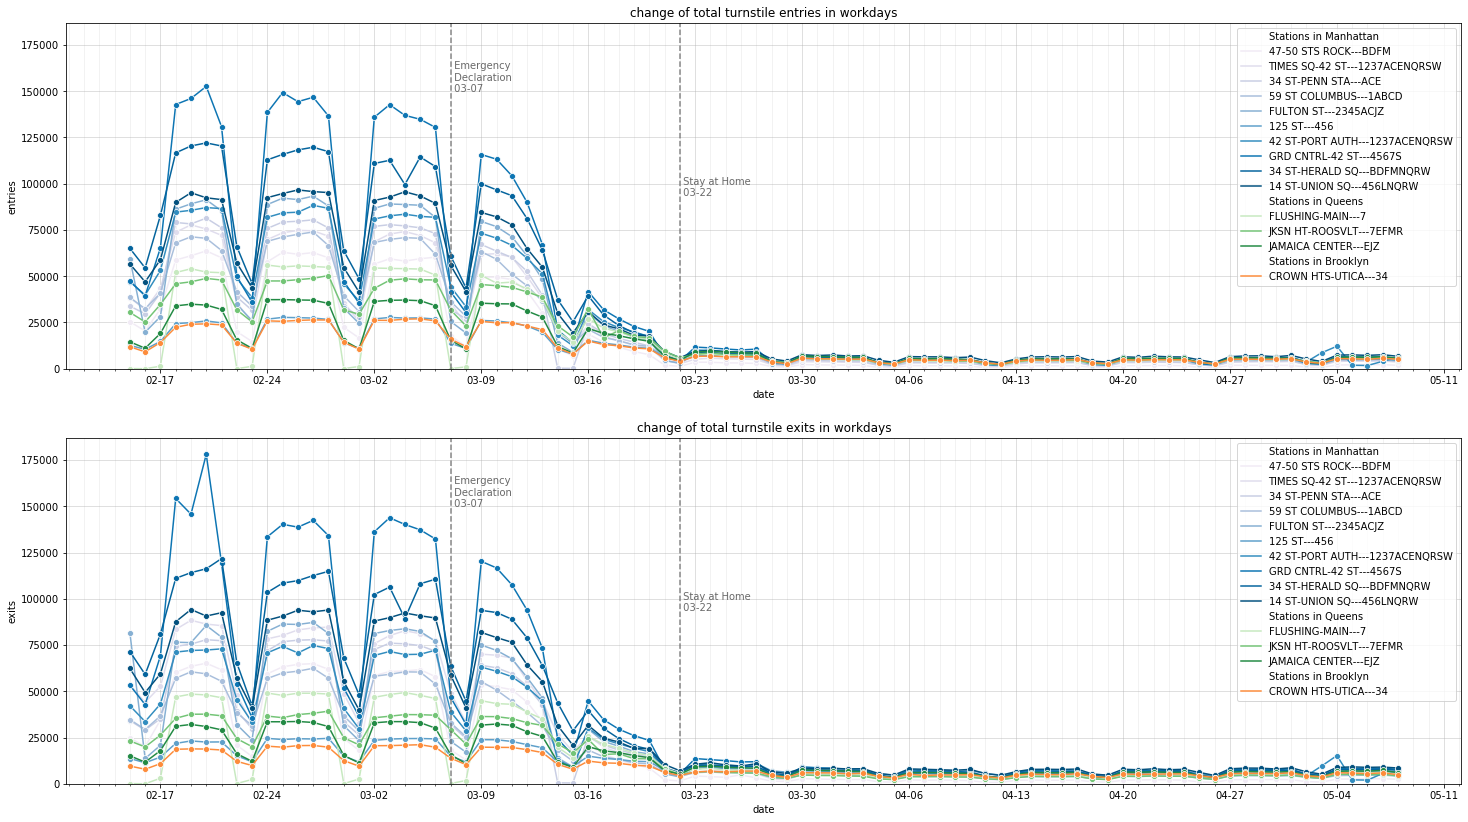

In [13]:
def plot_top_stations(top_ent, top_exi, total, avg,
    top_boroughs=['Manhattan','Queens','Brooklyn'], borough_plates=['PuBu', 'Greens', 'Oranges'],
                      by_percentage=False, legend_config={}, annote=True):
    #  top stations in regular days, and in April
    top_stations = pd.concat([top_ent, top_exi]).drop_duplicates()
    # join average
    station_avg_loc = pd.merge(top_stations, avg).sort_values('april_avg_entries', ascending=True)
    print(station_avg_loc[['STATION','lines','borough','april_avg_entries']])
    # by borough
    station_by_borough = []
    for b in top_boroughs:
        station_by_borough.append(station_avg_loc.loc[station_avg_loc.borough==b])
    # join total
    total_by_borough = []
    for i in range(len(top_boroughs)):
        station_total = pd.merge(station_by_borough[i], total)
        station_total['entries by percentage'] = station_total.entries/station_total.regular_avg_entries
        station_total['exits by percentage'] = station_total.exits/station_total.regular_avg_exits
        station_total['Stations in ' + top_boroughs[i]] = station_total.STATION + '---' + station_total.lines
        total_by_borough.append(station_total)
    # plot lines
    fig, axs = plt.subplots(nrows=2, figsize=(25, 14))
    for i in range(len(top_boroughs)):
        ent_key = 'entries'
        exi_key = 'exits'
        if by_percentage:
            ent_key = 'entries by percentage'
            exi_key = 'exits by percentage'
        station_num = len(station_by_borough[i].index)
        sns.lineplot(ax=axs[0], x="date", y=ent_key, hue='Stations in ' + top_boroughs[i],
                 palette=sns.color_palette(borough_plates[i], n_colors=station_num),
                 data=total_by_borough[i], marker='o')
        sns.lineplot(ax=axs[1], x="date", y=exi_key, hue='Stations in ' + top_boroughs[i],
                 palette=sns.color_palette(borough_plates[i], n_colors=station_num),
                 data=total_by_borough[i], marker='o')
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.grid(linestyle='-',alpha=0.5, which='major')
        ax.grid(linestyle='-',alpha=0.2, which='minor')
        ax.legend(**legend_config)
    # same y scale in both plots
    ylim = axs[1].get_ylim()
    axs[0].set_ylim(0, ylim[1])
    axs[1].set_ylim(0, ylim[1])
    # annotations
    if annote:
        for i, ax in enumerate(axs):
            # dates
            # 3-7 emergency declaration
            axs[i].axvline(x=dt.datetime(2020,3,7), linestyle='dashed', color='dimgray', alpha=0.8)
            axs[i].text(x=dt.datetime(2020,3,7), y=ylim[1]*0.8,
                        s=' Emergency\n Declaration\n 03-07', color='dimgray')
            # 3-22 stay at home
            axs[i].axvline(x=dt.datetime(2020,3,22), linestyle='dashed', color='dimgray', alpha=0.8)
            axs[i].text(x=dt.datetime(2020,3,22), y=ylim[1]*0.5, s=' Stay at Home\n 03-22', color='dimgray')
        axs[0].title.set_text('change of total turnstile entries in workdays')
    axs[1].title.set_text('change of total turnstile exits in workdays')
    plt.show()
plot_top_stations(top_ent, top_exi, total.loc[total.date >= pd.to_datetime('2020-02-15')], station_avg_loc)

            STATION         lines    borough  april_avg_entries
8    47-50 STS ROCK          BDFM  Manhattan        1685.636364
6    TIMES SQ-42 ST  1237ACENQRSW  Manhattan        3288.136364
5    34 ST-PENN STA           ACE  Manhattan        3594.818182
7    59 ST COLUMBUS         1ABCD  Manhattan        4384.045455
13    FLUSHING-MAIN             7     Queens        4433.636364
3         FULTON ST      2345ACJZ  Manhattan        4723.409091
12           125 ST           456  Manhattan        4766.590909
11  JKSN HT-ROOSVLT         7EFMR     Queens        4772.909091
10  CROWN HTS-UTICA            34   Brooklyn        4810.818182
4   42 ST-PORT AUTH  1237ACENQRSW  Manhattan        5197.090909
0   GRD CNTRL-42 ST         4567S  Manhattan        5329.227273
1   34 ST-HERALD SQ      BDFMNQRW  Manhattan        5360.227273
9    JAMAICA CENTER           EJZ     Queens        5564.409091
2    14 ST-UNION SQ      456LNQRW  Manhattan        6485.000000


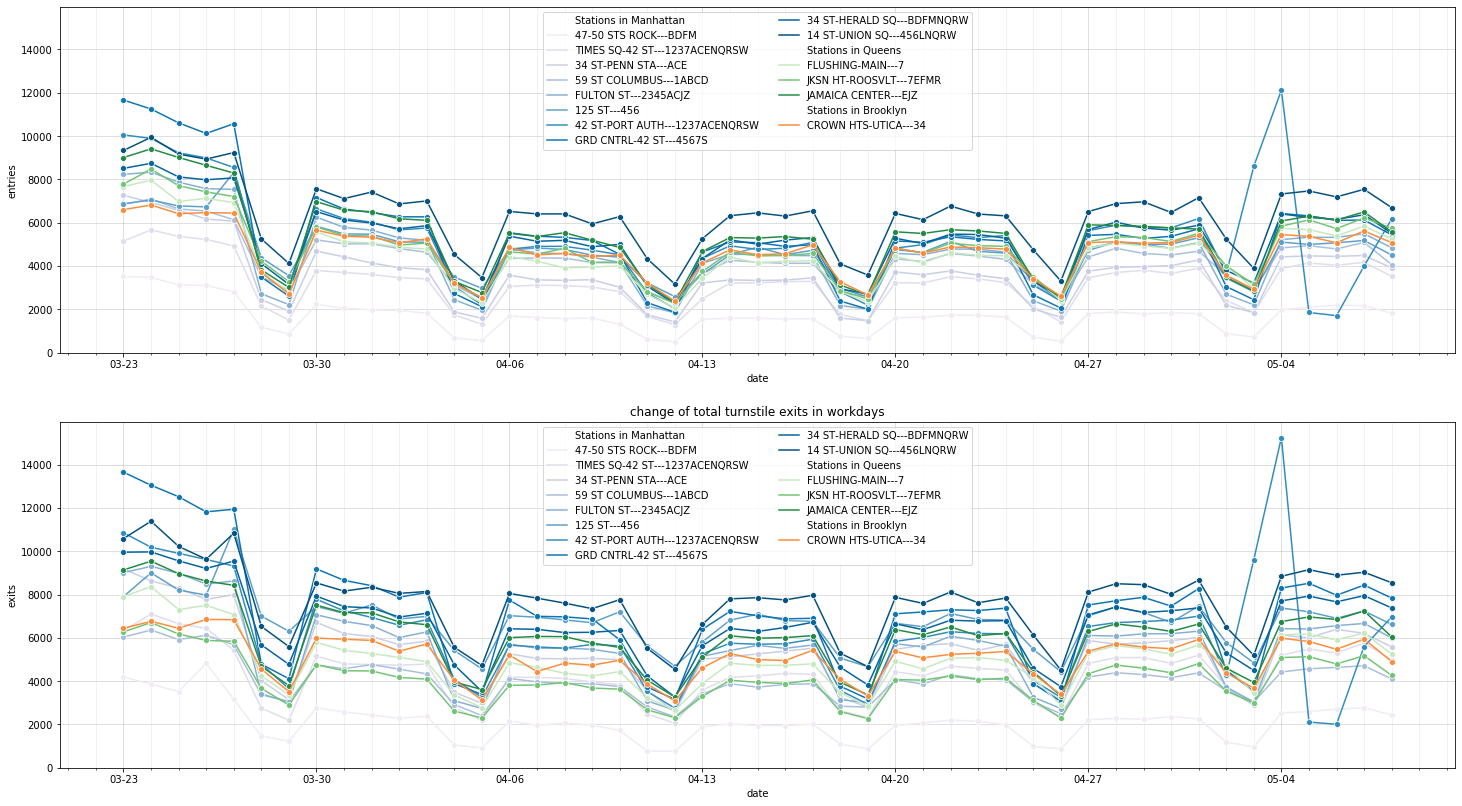

In [14]:
plot_top_stations(top_ent, top_exi, total.loc[total.date >= pd.to_datetime('2020-03-23')], station_avg_loc,
    legend_config={'ncol':2}, annote=False)

## Change Percentage

            STATION         lines    borough  april_avg_entries
8    47-50 STS ROCK          BDFM  Manhattan        1685.636364
6    TIMES SQ-42 ST  1237ACENQRSW  Manhattan        3288.136364
5    34 ST-PENN STA           ACE  Manhattan        3594.818182
7    59 ST COLUMBUS         1ABCD  Manhattan        4384.045455
13    FLUSHING-MAIN             7     Queens        4433.636364
3         FULTON ST      2345ACJZ  Manhattan        4723.409091
12           125 ST           456  Manhattan        4766.590909
11  JKSN HT-ROOSVLT         7EFMR     Queens        4772.909091
10  CROWN HTS-UTICA            34   Brooklyn        4810.818182
4   42 ST-PORT AUTH  1237ACENQRSW  Manhattan        5197.090909
0   GRD CNTRL-42 ST         4567S  Manhattan        5329.227273
1   34 ST-HERALD SQ      BDFMNQRW  Manhattan        5360.227273
9    JAMAICA CENTER           EJZ     Queens        5564.409091
2    14 ST-UNION SQ      456LNQRW  Manhattan        6485.000000


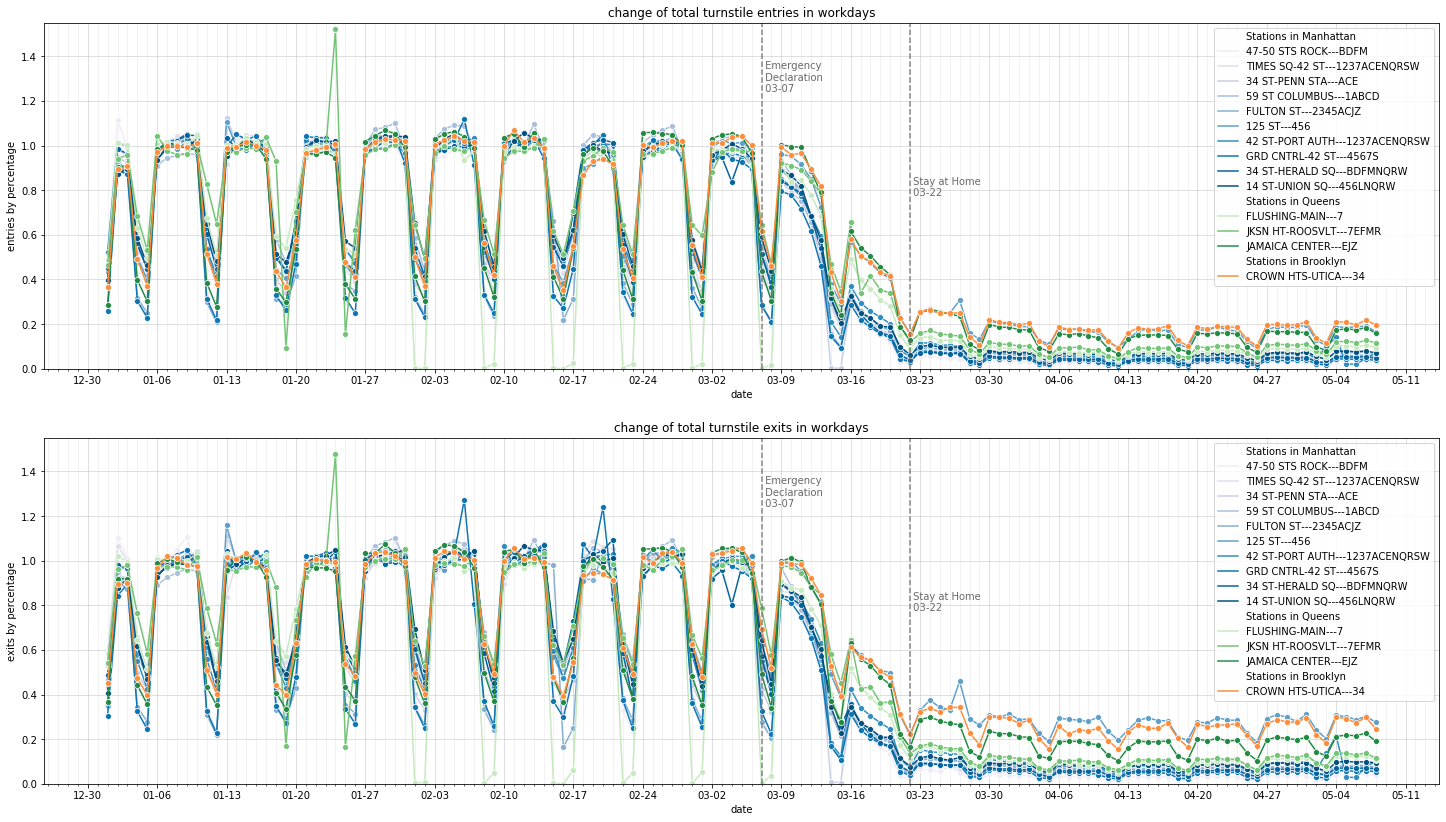

In [15]:
plot_top_stations(top_ent, top_exi, total,
    station_avg_loc, by_percentage=True)

            STATION         lines    borough  april_avg_entries
8    47-50 STS ROCK          BDFM  Manhattan        1685.636364
6    TIMES SQ-42 ST  1237ACENQRSW  Manhattan        3288.136364
5    34 ST-PENN STA           ACE  Manhattan        3594.818182
7    59 ST COLUMBUS         1ABCD  Manhattan        4384.045455
13    FLUSHING-MAIN             7     Queens        4433.636364
3         FULTON ST      2345ACJZ  Manhattan        4723.409091
12           125 ST           456  Manhattan        4766.590909
11  JKSN HT-ROOSVLT         7EFMR     Queens        4772.909091
10  CROWN HTS-UTICA            34   Brooklyn        4810.818182
4   42 ST-PORT AUTH  1237ACENQRSW  Manhattan        5197.090909
0   GRD CNTRL-42 ST         4567S  Manhattan        5329.227273
1   34 ST-HERALD SQ      BDFMNQRW  Manhattan        5360.227273
9    JAMAICA CENTER           EJZ     Queens        5564.409091
2    14 ST-UNION SQ      456LNQRW  Manhattan        6485.000000


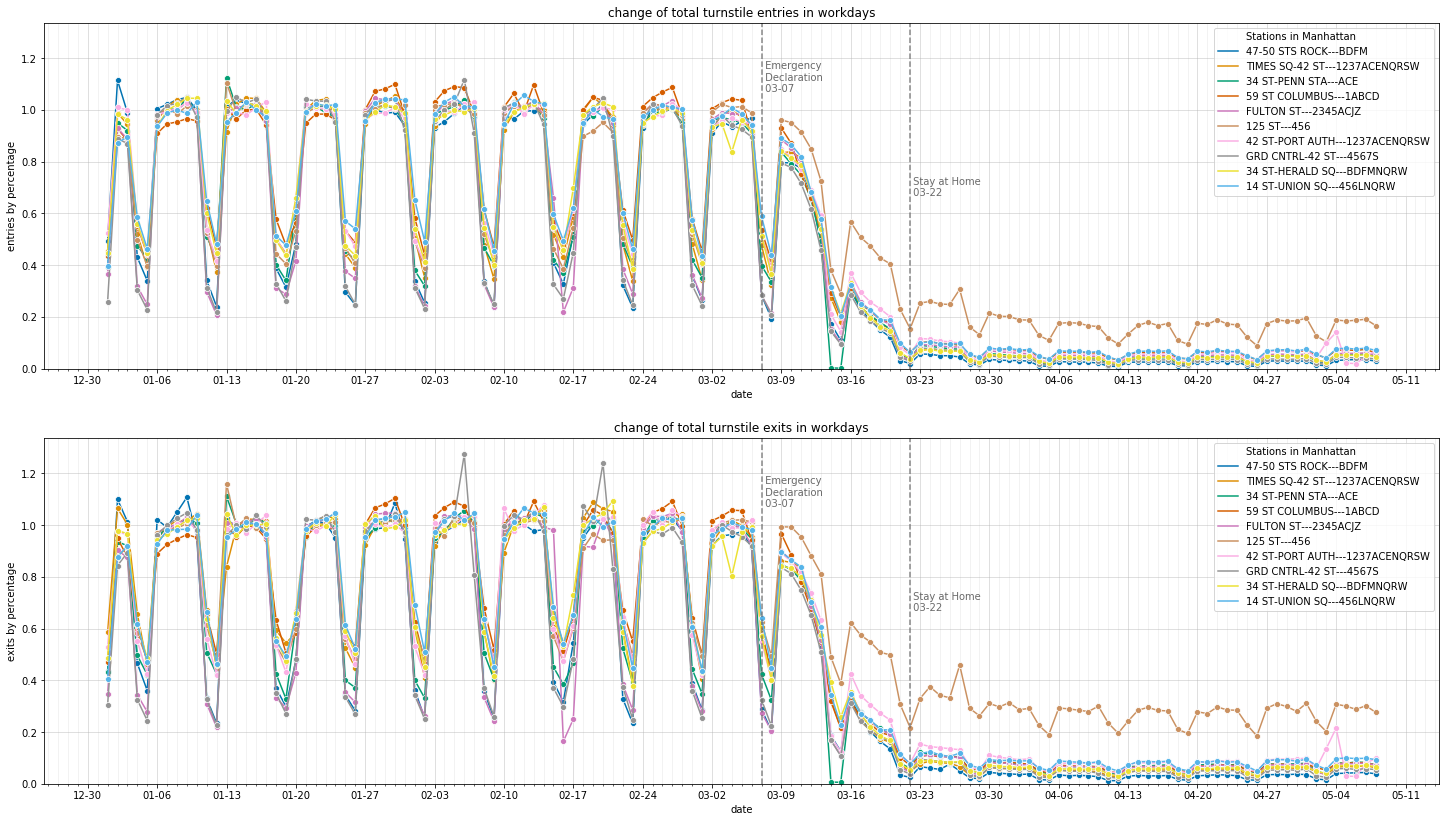

In [16]:
# manhattan only
plot_top_stations(top_ent, top_exi, total,station_avg_loc,
    top_boroughs=['Manhattan'], borough_plates=['colorblind'],by_percentage=True)

## Map

In [17]:
#TBD

# 3.Changes by timeslot